<a href="https://colab.research.google.com/github/ahitagnied/deep-learning/blob/main/01-deep-neural-networks/013-alex-net/alex_net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## AlexNet: How Does It Work?

AlexNet is a scaled up DNN, with 8 layers: 5 Convolutional Layers, and 3 FC Dense Layers. It was trained on the ILSVRC dataset on roughly 1.2 million coloured images: roughly 1000 images for each of the 1000 classes.

### **Understanding the Model Architecture:**

The input was a 3 channel input 227 x 227 x 3 and returns which class the image belongs to. The first layer is a Convolutional Layer with 96 kernels. Each kernel has a size of 11 x 11 and a stride of 4, which outputs a shape of 55 x 55 x 96. This is subjected to a MaxPooling layer with a filter size of 3 x 3 with a stride of 2. The resultant output was 27 x 27 x 96 which is then passed to another CL with kernel size of 5 x 5 and a stride of 1 and padding of 2 pixels is applied to both size to retain the input dimensions of 27 x 27.


This this CL, 256 kernels are used and so the output is 27 x 27 x 256. This is followed by another MaxPool Layer which reduces the size to 13 x 13 x 256. After this 3 other CLs are applied, with the same parameters. The first two have 344 kernels, and the last has 256. This is then passed onto a 3 FC Dense Layers and finally a softmax is applied to get the output.

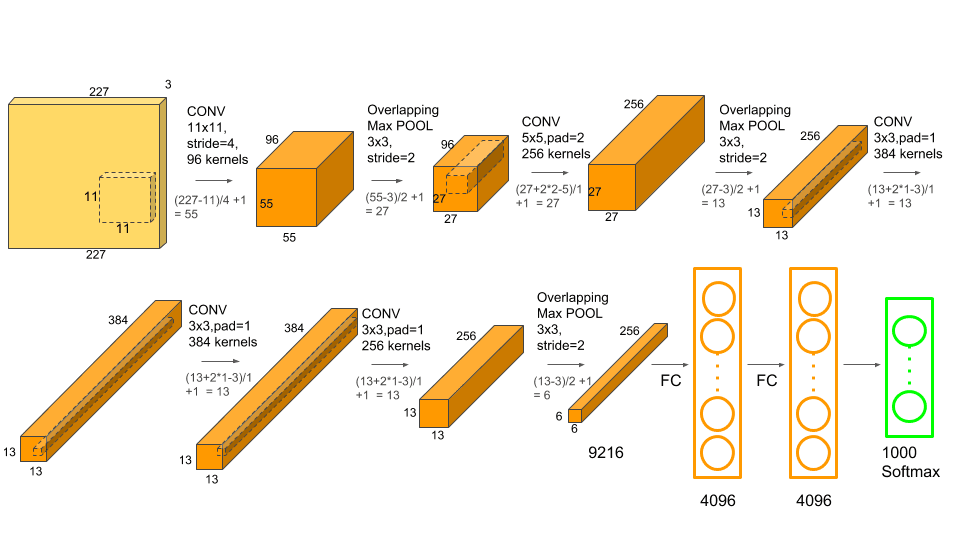

AlexNet has 60M parameters! Despite the large dataset (1.2 million images) the model is very prone to overfitting. To help this a number of steps were taken.

### **Helping Overfitting:**

> Overlapping Pooling: Pooling layers in CNNs summarize the outputs of neighboring groups of neurons in the same kernel map. Traditionally, the neighborhoods summarized by adjacent pooling units do not overlap. AlexNets implementing MaxPool filters of size 3 x 3 with a stride of 2, which has been overserved to slightly help with preventing overfitting.

> Using ReLU instead of tanh: Deep convolutional neural net-
works with ReLUs train several times faster than their
equivalents with tanh units.

Sigmoids and tanh are prone to saturation as their output values are cut-off at 1. In comparison RELU or max(0, x) does not have an upper-bound. Meaning, ReLUs do not require input normalization to prevent them from saturating, and so a neuron with learns as long as there is a positive input.

There are several other steps taken such as using 2 GPUs insetad of 1 and choosing which outputs are pushed onto the next layers. Along with this Local Response Normalization on the ReLUs, and some miinor data augmentation was performed.

Here, we'll implement AlexNet on the CelebA database.

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn.functional as F

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import shutil
import os
import zipfile

device = ("cuda" if torch.cuda.is_available() else "cpu") # Use GPU for training

In [2]:
class AlexNet(nn.Module):
  def __init__(self, nclasses = 2) -> None:
    super().__init__()

    self.conv = nn.Sequential(
        nn.Conv2d(3, 64, kernel_size = 11, stride = 4, padding = 2),
        nn.ReLU(inplace = True),
        nn.MaxPool2d(3, 2),

        nn.Conv2d(64, 192, kernel_size = 5, padding = 2),
        nn.ReLU(inplace = True),
        nn.MaxPool2d(3, 2),

        nn.Conv2d(192, 384, kernel_size = 3, padding = 1),
        nn.ReLU(inplace = True),

        nn.Conv2d(384, 256, kernel_size = 5, padding = 2),
        nn.ReLU(inplace = True),

        nn.Conv2d(256, 256, kernel_size = 5, padding = 2),
        nn.ReLU(inplace = True),
        nn.MaxPool2d(3, 2)
    )

    self.avgpool = nn.AdaptiveAvgPool2d((6, 6))

    self.linear = nn.Sequential(
        nn.Dropout(),
        nn.Linear(256 * 6 * 6, 4096),
        nn.ReLU(inplace = True),

        nn.Dropout(),
        nn.Linear(4096, 4096),
        nn.ReLU(inplace = True),

        nn.Linear(4096, nclasses)
    )

  def forward(self, x):
      x = self.conv(x)
      x = self.avgpool(x)
      x = torch.flatten(x, 1)
      x = self.linear(x)
      return torch.sigmoid(x)

In [3]:
!mkdir faces
!wget https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/celeba.zip

--2025-01-06 14:48:01--  https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/celeba.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.192.24, 52.219.113.48, 52.219.117.152, ...
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.192.24|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1443490838 (1.3G) [application/zip]
Saving to: ‘celeba.zip’

celeba.zip          100%[===================>]   1.34G  76.3MB/s    in 20s     

2025-01-06 14:48:21 (68.1 MB/s) - ‘celeba.zip’ saved [1443490838/1443490838]



In [4]:
with zipfile.ZipFile("celeba.zip", "r") as zip_ref:
  zip_ref.extractall("faces/")

In [5]:
root = "faces/img_align_celeba/"
img_list = os.listdir(root)
print(f"Total images: {len(img_list)}")

Total images: 202599


In [6]:
df = pd.read_csv("list_attr_celeba.csv.zip")
df = df[['image_id', 'Smiling']]

In [7]:
!rm -rf data
!mkdir data && mkdir data/smile && mkdir data/nosmile

In [8]:
num = 1500; s0, s1 = 0, 0

for i, (_, i_row) in enumerate(df.iterrows()):
  if s0 < num:
    if i_row['Smiling'] == 1:
      s0 += 1
      shutil.copy('faces/img_align_celeba/' + i_row['image_id'], 'data/smile/' + i_row['image_id'])
  else:
    if s1 < num:
      if i_row['Smiling'] == -1:
        s1 += 1
        shutil.copy('faces/img_align_celeba/' + i_row['image_id'], 'data/nosmile/' + i_row['image_id'])

  if s0 == num and s1 == num:
    break

In [9]:
from torchvision import transforms
!rm -rf data/.ipynb_checkpoints

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

celeba_dataset = datasets.ImageFolder(root="data", transform=transform)
print(len(celeba_dataset))

3000


In [10]:
train, test = torch.utils.data.random_split(celeba_dataset, [2250, 750])

In [17]:
an = AlexNet()

In [18]:
trainLoader = DataLoader(train, batch_size = 64, shuffle = True)
testLoader = DataLoader(test, batch_size = 64, shuffle = True)

optimiser = torch.optim.Adam(an.parameters(), lr=0.0001)
loss_func = nn.CrossEntropyLoss()

In [19]:
import time

start = time.time()

epochs = 20
trainLoss = []

for i in range(epochs):
  for b, (x, y) in enumerate(trainLoader):
    y_pred = an(x)
    loss = loss_func(y_pred, y)

    optimiser.zero_grad() # Set all grads to 0 to be updated after BP

    # BP
    loss.backward()
    optimiser.step() # Update weights

    # Updates
    if b%30 == 0:
      print(f"Epoch: {i}, Batch: {b}, Training Loss: {loss.item()}")
      trainLoss.append(loss.item())

end = time.time()
print(f"Total time taken: {end-start}")

Epoch: 0, Batch: 0, Training Loss: 0.6930881142616272
Epoch: 0, Batch: 30, Training Loss: 0.6947203278541565
Epoch: 1, Batch: 0, Training Loss: 0.694897472858429
Epoch: 1, Batch: 30, Training Loss: 0.689583957195282
Epoch: 2, Batch: 0, Training Loss: 0.6985363960266113
Epoch: 2, Batch: 30, Training Loss: 0.616421103477478
Epoch: 3, Batch: 0, Training Loss: 0.5423114895820618
Epoch: 3, Batch: 30, Training Loss: 0.5444390177726746
Epoch: 4, Batch: 0, Training Loss: 0.5762361288070679
Epoch: 4, Batch: 30, Training Loss: 0.523069441318512
Epoch: 5, Batch: 0, Training Loss: 0.4343124330043793
Epoch: 5, Batch: 30, Training Loss: 0.39932557940483093
Epoch: 6, Batch: 0, Training Loss: 0.4516066908836365
Epoch: 6, Batch: 30, Training Loss: 0.5212646722793579
Epoch: 7, Batch: 0, Training Loss: 0.4726394712924957
Epoch: 7, Batch: 30, Training Loss: 0.3991647958755493
Epoch: 8, Batch: 0, Training Loss: 0.47426968812942505
Epoch: 8, Batch: 30, Training Loss: 0.4726217985153198
Epoch: 9, Batch: 0, T

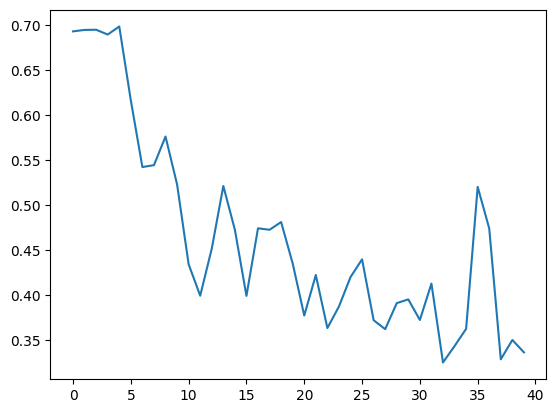

In [20]:
plt.plot(trainLoss)

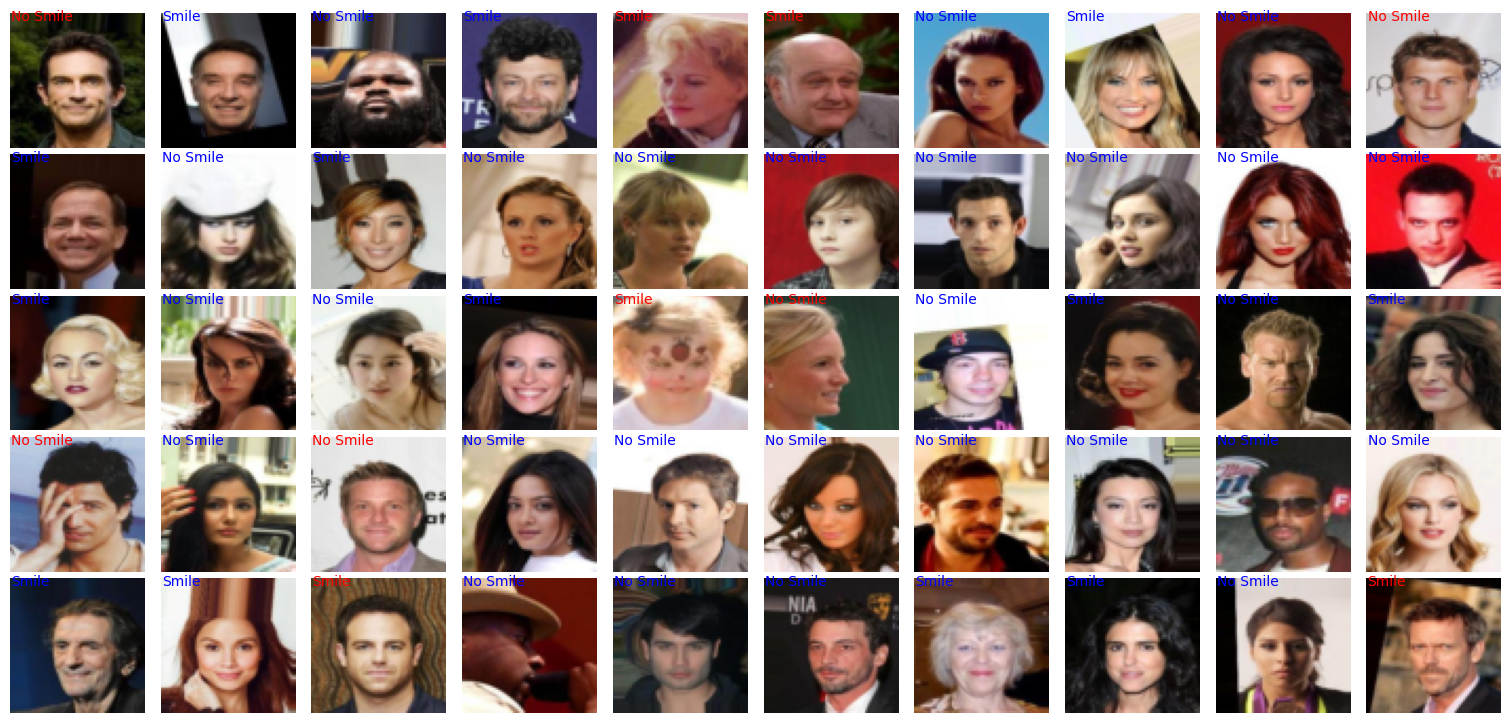

In [24]:
with torch.no_grad():
    images, labels = next(iter(testLoader))
    preds = an(images)
    preds = torch.argmax(preds, dim=1)

# Plot in single figure
fig, axs = plt.subplots(5, 10, figsize=(15, 7))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

class_names = ['No Smile', 'Smile']  # Binary classification

for idx, (img, pred, label) in enumerate(zip(images[:50].cpu(), preds, labels)):
    ax = axs[idx//10, idx%10]
    ax.imshow(img.permute(1, 2, 0))
    ax.axis('off')
    color = 'blue' if pred == label else 'red'
    ax.text(0, 3, class_names[pred], color=color)

plt.show()